In [134]:
import numpy as np
import math
from scipy.optimize import linprog
from abc import ABC
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D
import pulp as pl

In [135]:
plan = """
Data Generation Parameters
    What distribution: uniform, gaussian
    Data type: bit arrays, int arrays

DP Parameters:
    Laplace: Epsilon and sensitivity of the query function (depends on the data / attack)
    Gaussian: Same as above + delta

Attack Parameters
    Dinur Nissim: 
        function t(n) (# of queries)
        dn_epsilon
    
    CN19: 
        t(n) number of queries 
        
Bit arrays + Laplace
    fix dn_epsilon, vary # queries and laplace epsilon
    
1. Dinur Nissim + No DP 
    instantly solves

2. Laplace vs. Gaussian 
    # of queries needed queries needed to reconstrinct 95% or a few %s vs. epsilon; fix delta or try a couple deltas
        n 1.1n 1.2n etc 

3. When you noise, how much usefulness lost? 
    Fix everything (most queries from prev experiment) except amount of noise and plot. Plot two axes of epsilon vs both % reconstructed and accuracy maintained

4. CN19 Attack
    With bits, just see how much the # of queries decreases vs dinur nissim for a few different Ns. Keep epsilon as what we said was "most optimal" 

5. CN19 With Integers
    Normal vs. Uniform vs. Some bimodal/multimodal distributions 
    
6. Michael w/ a real world attack 

""" 

In [136]:
def generate_bit_data(n = 1000): 
    """
    Generate an array of n random bits.
    """
    return np.random.randint(0,2,n)

def generate_int_data(n = 1000, k = 5): 
    """
    Generate an array of n random numbers in [0...k].
    """
    return np.random.randint(0,k+1,n)

In [168]:
class Mechanism(ABC): 
    pass

class NoiseMechanism(Mechanism):
    """
    A mechanism whose queries return the true result plus noise generated by noise_generator. 
    noise_generator takes 0 arguments and returns a value of the same type as query
    """

    def __init__(self, dataset, noise_generator):
        self.dataset = dataset
        self.length = len(dataset)   
        self.noise_generator = noise_generator
        
    def get_len(self):
        return self.length
    
    def get_raw_data(self):
        return self.dataset

    def query(self, indices): 
        result = np.sum(self.dataset[indices])
        noise = self.noise_generator()
        return result + noise

    
class TrivialMechanism(NoiseMechanism):
    """
    A noise mechanism that draws its noise from the Laplace(sensitivity/epsilon) distribution
    """
    def __init__(self, dataset):
        noise = lambda : 0
        super().__init__(dataset, noise)
    
    
class LaplaceMechanism(NoiseMechanism):
    """
    A noise mechanism that draws its noise from the Laplace(sensitivity/epsilon) distribution
    """
    def __init__(self, dataset, epsilon, sensitivity=1):
        self.scale = (sensitivity/epsilon)
        noise = lambda : np.random.laplace(loc=0,scale = self.scale, size=None)
        super().__init__(dataset, noise)    
    
    
class GaussianMechanism(NoiseMechanism):
    """
    A noise mechanism that draws its noise from the Normal(2*(sensitivity^2)log(1/25/delta)/(epsilon^2))distribution
    """
    
    def __init__(self, dataset, epsilon, delta, sensitivity = 1):
        self.scale = (2 * (sensitivity ** 2) * math.log(1.25/delta)) / (epsilon ** 2)
        noise_generator = lambda : np.random.normal(loc=0, scale=self.scale, size=None)
        super().__init__(dataset, noise_generator)
    
    

def discover_accuracy(mech, num_queries = 100):
    """
    Takes a mechanism and calculates the (nonnormalized) average error per randomly generated subset query.
    """
    baseline = TrivialMechanism(mech.get_raw_data())
    l = mech.get_len()
    
    def generate_query(n):
        # Generate a random subset of [n] by generating a list of bits and convert to indices
        q_j = np.random.randint(0,2,n)
        indices2 = q_j.nonzero()
        return (q_j, indices2) 
    
    running_total = 0
    for i in range(num_queries): 
        q, _ = generate_query(l)
        true_value = baseline.query(q)
        mech_value = mech.query(q)
        running_total += abs(true_value - mech_value)
    
    return running_total / num_queries

In [138]:
def dinur_nissim(mech, gen_t = lambda n : n * (math.log2(n) ** 2),  epsilon = 0.5, should_log = False, **kwargs):
    """
    Perform a dinur_nissim attack on the dataset, mediated by mech, a Mechanism object. 
    
    epsilon and t are the two hyperparameters of the attack. gen_t generates int-valued t as a function of n, the size of the dataset.
    
    Wrap all logging behond `should_log`
    """
    
    n = mech.get_len()
    t = int(gen_t(n))

    def generate_query():
        # Generate a random subset of [n] by generating a list of bits and convert to indices
        q_j = np.random.randint(0,2,n)
        indices2 = q_j.nonzero()
        return (q_j, indices2) 
    
    # Make t queries to the mechanism. A_ub and b_ub are respectively the coefficient matrix 
    #   and upper bound for the linear program 
    A_ub = []
    b_ub = []
    for _ in range(int(t)):
        q, indices = generate_query()
        answer = mech.query(indices)
        A_ub.append(q)
        b_ub.append(answer + epsilon)
        A_ub.append(-1 * q)
        b_ub.append(epsilon - answer)
    A_ub = np.vstack(A_ub)
    b_ub = np.array(b_ub)
    # Rounding Phase: round the results of the LP into integers
    
    if(should_log):
        print(f"Solving LP with {len(b_ub)} constraints")
    
    program_result = linprog(np.zeros(n), np.vstack(A_ub), b_ub, bounds=(0,1), options={"maxiter" : 3000000000})

    if(should_log):    
        print(f"Done w/ LP")
    round_vector = np.vectorize(round, otypes=[int])
    return round_vector(program_result["x"])



In [139]:
def cn19(mech, gen_t = lambda n : n * (math.log2(n) ** 2), k = 1, should_log = False, **kwargs):
    """
    Performs the attack from CN19 on the dataset, mediated by mech, a Mechanism object. 
    
    k and t are the two hyperparameters of the attack. 
    
    gen_t generates int-valued t as a function of n, the size of the dataset.
    
    k is the number such that the data take values in [0...k].
    
    Wrap all logging behond `should_log`
    """
    
    n = mech.get_len()
    t = int(gen_t(n))

    def generate_query():
        # Generate a random subset of [n] by generating a list of bits and convert to indices
        q_j = np.random.randint(0,2,n)
        indices2 = q_j.nonzero()
        return (q_j, indices2) 
    
    # Set up the LP using pulp 
    lp = pl.LpProblem("Decoding", pl.LpMinimize)
    
    # x_i contains the i'th entry in the candidate database 
    xs = [pl.LpVariable(str(i), 0, k) for i in range(n)]
    # abs_e_qs stores the absolute values of the e_q, the difference between the answer and q(x')
    abs_e_qs = []
    # Generate variables based on the query 
    for i in range(t):
        q, indices = generate_query()
        answer = mech.query(indices)
        # Get q(x') by evaluating our query on the candidate database 
        q_x = [(xs[j], q[j]) for j in range(n)]
        abs_e_q = pl.LpVariable(("abs_e_q" + str(i)))
        abs_e_qs.append(abs_e_q)
        # Add a variable to represent the sum of a_q - q(x') 
        temp_sum = pl.LpVariable("temp_sum" + str(i))
        # Add the constraints such that abs_e_qs will become the absolute value of a_q - q(x')
        lp += (temp_sum == (answer - pl.LpAffineExpression(q_x)))
        lp += (abs_e_q >= temp_sum)
        lp += (abs_e_q >= -temp_sum)
        
    # We want our objective to be the sum of |e_q| over all queries
    lp += pl.lpSum(abs_e_qs)
    
    if(should_log):
        print(f"Solving LP with {len(b_ub)} constraints")
    status = lp.solve(pl.PULP_CBC_CMD(msg=False))

    if(should_log):    
        print(f"Done w/ LP")
    # Return the rounded values
    return [round(pl.value(x)) for x in xs]

In [140]:
# Utilities
def percent_reconstructed(data, results): 
    """
    What percentage of entries in data match those in results.
    """
    n = len(data)
    return 1 - ((np.count_nonzero(data!=results))/n)

class ConstantFunction:
    # This should not be a class but it did something else before
    def __init__(self, val):
        self.val = val
    
    def __call__(self, _x):
        return self.val

In [141]:
_default_dn_args = {"epsilon" : 0.5, "should_log" : False}

# Run a set of experiments. See usage below.
def run_experiment(ns, 
                   mechanism_class, 
                   mech_args, 
                   dn_epsilon, 
                   t_generators, 
                   should_log=True, 
                   output_filename = None, 
                   attacker=dinur_nissim, 
                   data_maker = generate_bit_data, 
                   attacker_args=_default_dn_args): 
    
    results_df =  pd.DataFrame(columns=["n", 
                              *list(mech_args[0].keys()), 
                              "dn_epsilon", 
                              "num_queries", 
                              "percent_reconstructed", 
                              "mechanism_error"]) 
    
    def make_entry(mech_arg, n, dn_epsilon, t, pc_reconstructed, mechanism_error): 
        res = {x : [mech_arg[x]] for x in mech_arg.keys()}
        res.update (
            {
                "n" : [n],
                "dn_epsilon" : [dn_epsilon],
                "num_queries" : [t],
                "percent_reconstructed" : pc_reconstructed, 
                "mechanism_error" : mechanism_error
            }
        )
        return pd.DataFrame.from_dict(res)
 
    total = len(ns)*len(mech_args)*len(t_generators)
    
    if(should_log):
        print(f"Running {total} experiments")
        
    so_far = 0
    for n in ns:
        for mech_arg in mech_args:
            # New dataset and mech for each size/mechanism params pair
            data = data_maker(n=n)
            mech = mechanism_class(data, **mech_arg)
            mech_acc = discover_accuracy(mech)
            for t_generator in t_generators:
                attacker_args["epsilon"] = dn_epsilon
                result = attacker(mech, t_generator, **attacker_args)
                # Lambdas are hard to log so we log its application. We can probably abstract this better.
                t = int(t_generator(n))

                # Append new results 
                entry = make_entry(mech_arg, n, dn_epsilon, t, percent_reconstructed(data, result), mech_acc)
                results_df = pd.concat([results_df, entry], ignore_index=True)     
                so_far += 1
                if should_log:
                    print(f"Finished {so_far}/{total}")
                        
    if output_filename:
        if should_log:
            print(f"Writing results to {output_filename}")
        results_df.to_csv(output_filename, encoding='utf-8', header='true')
    return results_df

def read_results(filename):
    "Read results written by the function above"
    return pd.read_csv (filename, index_col=0)


In [142]:
# General plotting functions
def plot_3d(df, filter_cond, x1, x2, y, labels, title):
    """
    Make a 3d surface plot with y as a function of x1, x2. 
    x1,x2,y should be df series / arrays
    """
    df = filter_cond(df)
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_trisurf(df[x1], df[x2], df[y], cmap=cm.jet, linewidth=0.2)
    ax.set_xlabel(labels[0], fontsize=10)
    ax.set_ylabel(labels[1], fontsize=10)
    ax.set_zlabel(labels[2], fontsize=10)
    ax.set_title(title, fontsize=15)
    plt.show()
    return ax
    
def plot_single_x_multiple_subsets(df, 
                                   filter_cond, 
                                   x, 
                                   y, 
                                   divide_on, 
                                   dividers = None, 
                                   xlabel = "x", 
                                   ylabel = "y", 
                                   legend_formatter = lambda n : n, 
                                   title = "My graph"): 
    """
    Todo: Explain this
    """
    fig = plt.figure()
    ax = plt.gca()
    if divide_on is None: 
        s = df
        ax.plot(s[x], s[y])
    else:
        for div in dividers:
            s = df[df[divide_on] == div]
            ax.plot(s[x], s[y], label = legend_formatter(div))
        ax.legend()
    ax.set_title(title, fontsize=15)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return ax


In [143]:
# Some preliminary specific plots

def plot_3d_eps_t(df, title = "% Recon vs. T and Epsilon"):
    
    plot_3d(df, 
            filter_cond = lambda x : x, 
            x1 = "num_queries", 
            x2 = "epsilon", 
            y = "percent_reconstructed",
            labels = ['Num Queries', 'Epsilon', 'Proportion Reconstructed'], 
            title = title)

    
def plot_eps_multiple_t(df, ts, title="Success vs. Eps for various Ts"):
    plot_single_x_multiple_subsets(
        df=df,
        filter_cond = lambda x : x,
        x="epsilon",
        y="percent_reconstructed",
        divide_on="num_queries",
        dividers=ts,
        xlabel = "Epsilon",
        ylabel = "% Reconstructed", 
        legend_formatter = lambda x : f"{x} queries",
        title = title
    )

def plot_t_multiple_eps(df, epss, title="Success vs. T for various Epsilons"):
    plot_single_x_multiple_subsets(
        df=df,
        filter_cond = lambda x : x,
        x="num_queries",
        y="percent_reconstructed",
        divide_on="epsilon",
        dividers=epss,
        xlabel = "# Queries",
        ylabel = "% Reconstructed", 
        legend_formatter = lambda x : f"Epsilon = {x}",
        title = title
    )


def epsilon_thresshold(df, threshold = 0.95, title ="Queries vs. Epsilon"):
    """
    Plot # queries required to attain a propoertion reconstructed >- thresshold 
    """
    tres = df[df.percent_reconstructed >= threshold].groupby(df.epsilon).apply(lambda d : d[d.num_queries == d.num_queries.min()])

    return plot_single_x_multiple_subsets(
        df=tres,
        filter_cond = lambda x : x,
        x="epsilon",
        y="num_queries",
        divide_on=None,
        xlabel = "Epsilon",
        ylabel = "Queries Required", 
        title = title
    )

def recon_accuracy_tradeoff(df, title ="Accuracy and Percent Recon vs. Epsilon"):
    """
    Makes two plots: 
    
    Both have epsilon on the x axis. 
    First has mechanism error ("accuracy" proxy) on y axis 
    Second has % reconstructed.
    
    Tweak the accuracy metric defined in mechanisms.py to improve this.
    """
    acc = plot_single_x_multiple_subsets(
        df=df,
        filter_cond = lambda x : x,
        x="epsilon",
        y="mechanism_error",
        divide_on = None,
        xlabel = "Epsilon",
        ylabel = "Mechanism Error", 
        legend_formatter = lambda x : f"Epsilon = {x}",
        title = title
    )

    perc_rec = plot_single_x_multiple_subsets(
        df=df,
        filter_cond = lambda x : x,
        x="epsilon",
        y="percent_reconstructed",
        divide_on = None,
        xlabel = "Epsilon",
        ylabel = "% Reconstructed", 
        legend_formatter = lambda x : f"Epsilon = {x}",
        title = ""
    )

In [144]:
# Example usage. Essentially runs over the cartesian product of the lists [ns, mech_args, dn_epsilons, t_generators]
# test_run_2 = run_experiment(
#     ns = [1000], 
#     mechanism_class = LaplaceMechanism, 
#     mech_args = [{"epsilon": x} for x in [.1*y for y in range(3, 16)]], 
#     dn_epsilons=[.5], 
#     t_generators=([ConstantFunction(n) for n in [50*y for y in range(8, 14)]]), 
#     output_filename="data/laplace_n1000_dne0.5.csv'")

# two_epsilons = run_experiment(
#     ns = [1000], 
#     mechanism_class = LaplaceMechanism, 
#     mech_args = [{"epsilon": x} for x in [.1*y for y in range(7, 11)]], 
#     dn_epsilons=[0.1*x for x in range(1, 10)], 
#     t_generators=([lambda n: n, lambda n: 2*n])
#     output_filename="data/two_epsilons_test.csv'")
# test_run_2 = run_experiment(
#     ns = [100], 
#     mechanism_class = LaplaceMechanism, 
#     mech_args = [{"epsilon": x} for x in [.1*y for y in range(5,21)]], 
#     attacker_args = {"k" : 10},
#     dn_epsilon=.5, 
#     t_generators=([ConstantFunction(n) for n in [50*y for y in range(2, 6)]]), 
#     output_filename="data/laplace_n1000_dne0.5.csv'",
#     attacker = cn19,
#     data_maker=generate_int_data)


# test_run_5 = run_experiment(
#     ns = [100], 
#     mechanism_class = LaplaceMechanism, 
#     mech_args = [{"epsilon": x} for x in [.1*y for y in range(5,21)]], 
#     attacker_args = {"k" : 10},
#     dn_epsilon=10, 
#     t_generators=([ConstantFunction(n) for n in [50*y for y in range(2, 6)]]), 
#     output_filename="data/laplace_n1000_dne0.5.csv'",
#     attacker = dinur_nissim,
#     data_maker=generate_bit_data)

# test_run_6 = run_experiment(
#     ns = [100], 
#     mechanism_class = LaplaceMechanism, 
#     mech_args = [{"epsilon": x} for x in [.1*y for y in range(5,21)]], 
#     attacker_args = {"k" : 10},
#     dn_epsilon=10, 
#     t_generators=([ConstantFunction(n) for n in [50*y for y in range(2, 6)]]), 
#     output_filename="data/laplace_n1000_dne0.5.csv'",
#     attacker = cn19,
#     data_maker=generate_bit_data)



/var/folders/mk/ydf2207j325_0l9ph1swkbzc0000gq/T/ipykernel_30166/1971034895.py:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


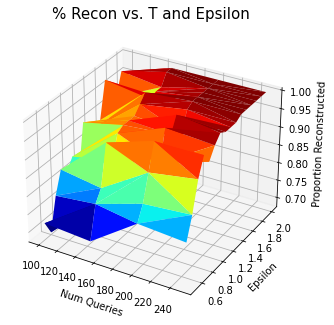

In [148]:
# # Read in the data from the above examples
test_run = read_results('data/laplace_n1000_dne0.5.csv')
two_epsilons = read_results('data/two_epsilons_test.csv')

plot_3d_eps_t(test_run_5)

/var/folders/mk/ydf2207j325_0l9ph1swkbzc0000gq/T/ipykernel_30166/1971034895.py:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


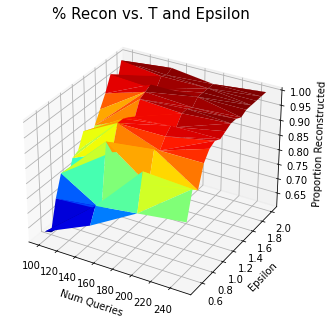

In [149]:
# Now just make some demo plots
# test_run
plot_3d_eps_t(test_run_6)

/var/folders/mk/ydf2207j325_0l9ph1swkbzc0000gq/T/ipykernel_30166/1971034895.py:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)


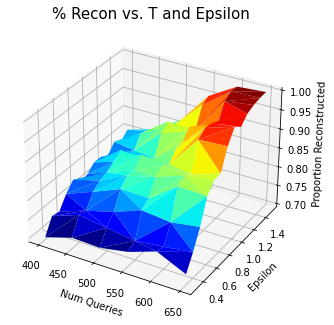

In [150]:
plot_3d_eps_t(test_run)

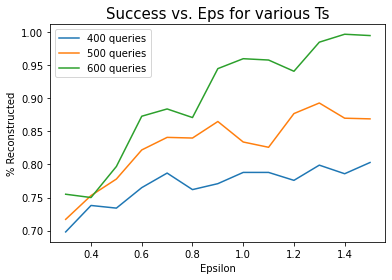

In [151]:
plot_eps_multiple_t(test_run, ts = [400, 500,  600])

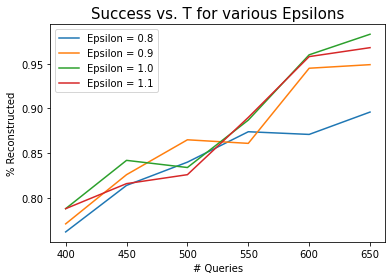

In [152]:
plot_t_multiple_eps(test_run, epss=[.1*y for y in range(8, 12)])

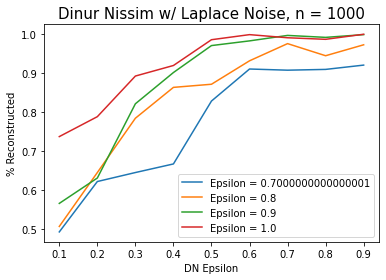

In [154]:
plot_t_single_eps(two_epsilons[two_epsilons.num_queries == 1000], [.1*y for y in range(7, 11)])

In [155]:
# def accuracy_experiment(mechanism_parameter_list, )

In [156]:



# data = generate_int_data(k=5, n=100)
# mech = LaplaceMechanism(data, epsilon=.5)
# percent_reconstructed(cn19(mech, k=5, gen_t=lambda n : 1000), data)

In [159]:
laplace_results_3 = run_experiment(
    ns = [500], 
    mechanism_class = LaplaceMechanism, 
    mech_args = [{"epsilon": x} for x in [.1*y for y in range(5,21)]], 
    dn_epsilon=10, 
    t_generators=([ConstantFunction(n) for n in [50*y for y in range(15, 16)]]), 
    output_filename="None")

Running 16 experiments
Finished 1/16
Finished 2/16
Finished 3/16
Finished 4/16
Finished 5/16
Finished 6/16
Finished 7/16
Finished 8/16
Finished 9/16
Finished 10/16
Finished 11/16
Finished 12/16
Finished 13/16
Finished 14/16
Finished 15/16
Finished 16/16
Writing results to None


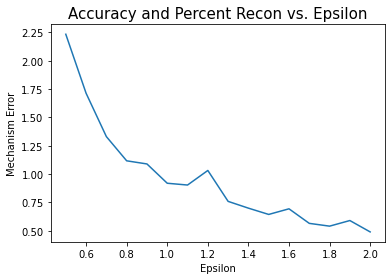

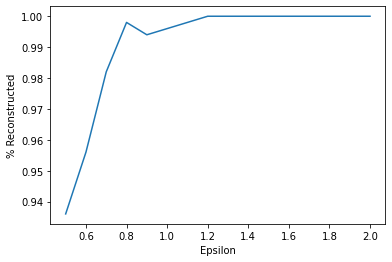

In [160]:
# laplace_results
laplace_results_3
recon_accuracy_tradeoff(laplace_results_3)

In [173]:
test_run_3 = run_experiment(
    ns = [1000], 
    mechanism_class = GaussianMechanism, 
    mech_args = [{"epsilon": x, "delta" : 1} for x in [.1*y for y in range(10,11)]], 
    dn_epsilon=[1], 
    t_generators=([ConstantFunction(n) for n in [50*y for y in range(13, 14)]]), 
    output_filename="data/isworking.csv'")

Running 1 experiments
Finished 1/1
Writing results to data/isworking.csv'


In [172]:
test_run_3

,n,epsilon,delta,dn_epsilon,num_queries,percent_reconstructed,mechanism_error
0,1000,1.0,0.11,[1],650,0.728,3.822148


<AxesSubplot:title={'center':'Queries Requried for 95% Recon Accuracy vs. Epsilon'}, xlabel='Epsilon', ylabel='Queries Required'>

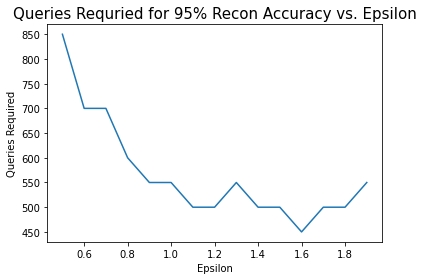

In [111]:
epsilon_thresshold(laplace_results, title="Queries Requried for 95% Recon Accuracy vs. Epsilon")

In [110]:
laplace_results_3

,n,epsilon,dn_epsilon,num_queries,percent_reconstructed,mechanism_error
0,500,0.5,10,750,0.918,2.238443
1,500,0.6,10,750,0.946,1.708885
2,500,0.7,10,750,0.978,1.413108
3,500,0.8,10,750,0.984,1.494420
4,500,0.9,10,750,0.992,1.107739
5,500,1.0,10,750,0.998,1.022205
6,500,1.1,10,750,1.000,0.855226
7,500,1.2,10,750,0.998,0.879253
8,500,1.3,10,750,1.000,0.772629
9,500,1.4,10,750,1.000,0.656053


In [108]:
# Very simple example
# data = generate_bit_data(n=500)
# mech = LaplaceMechanism(data, epsilon=100)
# dinur_nissim(mech, gen_t=lambda n : n)

# def plot_t_single_eps(df, epss):
#     plot_single_x_multiple_subsets(
#         df=df,
#         filter_cond = lambda x : x,
#         x="dn_epsilon",
#         y="percent_reconstructed",
#         divide_on="epsilon",
#         dividers=epss,
#         xlabel = "DN Epsilon",
#         ylabel = "% Reconstructed", 
#         legend_formatter = lambda x : f"Epsilon = {x}",
#         title = "Dinur Nissim w/ Laplace Noise, n = 1000"
#     )